<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/CNN/Proj3_CNN_FMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tasks:
1.   import the FMNIST datset
     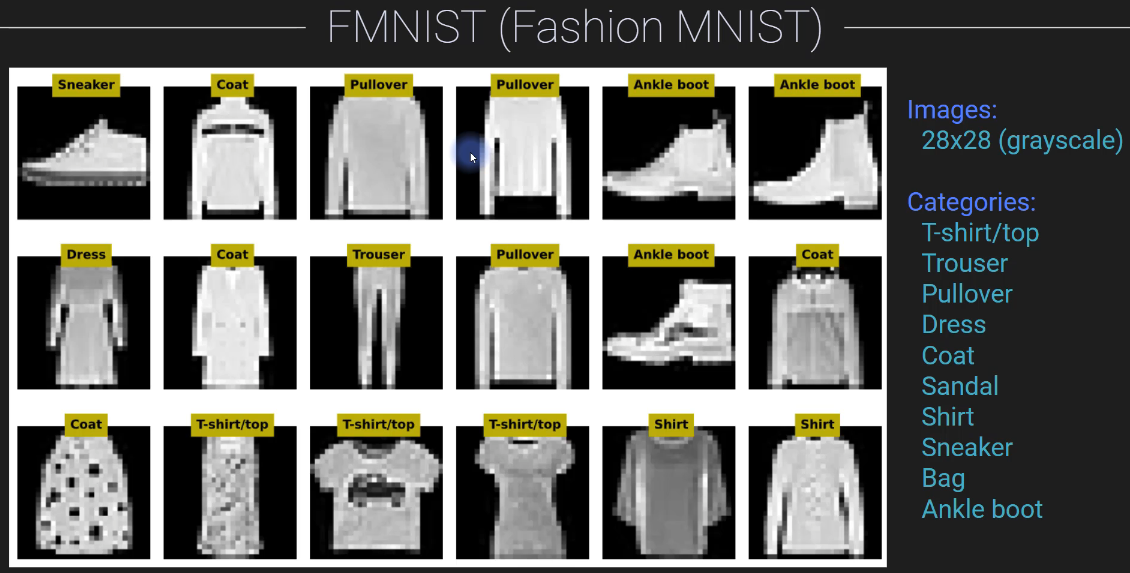
2.   create 3 partitions from the dataset (train/dev/test)
3.   apply some transformation(s)
4.   build a CNN model to categorize each image into a cetegory
5.   plot loss and accuracy vs. epochs for each partitio (train/dev/test)

# About FMNIST:

The Fashion MNIST datase contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 × 28 pixels).

I will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images.


In [1]:
# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import data:

In [3]:
# transformations
transform = T.Compose([ T.ToTensor(), # convert to tensor & normalize from [0, 255] -> [0, 1]
                        T.RandomHorizontalFlip(p=.5), # 50% probability
                        # torchvision.transforms.Normalize(mean, std, inplace=False)
                        # normalize pixel values from [0, 1] to [-1,1] by subtracting 0.5 from each pixel value and then dividing by 0.5
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform) # train=True -> training set
devtest  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform) # train=False -> dev/test set

# a random permutation of indices
randidx = np.random.permutation(10000)
# print(randidx) # eg: [9546 6633 4797 ... 1222 7671 8219]
# print(len(randidx)) # 10000

# split the devtest into devset and testset
devset  = Subset(devtest,randidx[:6000]) # 'torch.utils.data.dataset.Subset' object
testset = Subset(devtest,randidx[6000:])

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=len(devset)) # no mini-batch
test_loader  = DataLoader(testset, batch_size=len(testset)) # no mini-batch

100%|██████████| 26421880/26421880 [00:01<00:00, 18111303.03it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 265485.62it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5041908.92it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23044052.29it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
# check out the shapes of the datasets:
print('Data shapes (train/dev/test):')
print( trainset.data.shape )
print( len(devset) )
print( len(testset) )

# range of pixel intensity values
print('\nData value range:')
print( (torch.min(trainset.data),torch.max(trainset.data)) ) #[0,255]

# the unique categories
print('\nData categories:')
print( trainset.classes )

Data shapes (train/dev/test):
torch.Size([60000, 28, 28])
6000
4000

Data value range:
(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

Data categories:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


👆 train: 60000, dev: 6000, test: 4000, image size: 28x28, categories: 10

NOTE: The transformations are actually not applied to the images directly. Instead, the transformations are ***stored*** and they are applied to the images only when we ***export the data*** or when we ***pull a little batch*** of data out of these data loaders.

In [5]:
X,y = next(iter(test_loader))
print( X.data.shape )
print( y.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) ) # [-1,1]

torch.Size([4000, 1, 28, 28])
torch.Size([4000])

Data value range:
(tensor(-1.), tensor(1.))


In [6]:
X.shape

torch.Size([4000, 1, 28, 28])

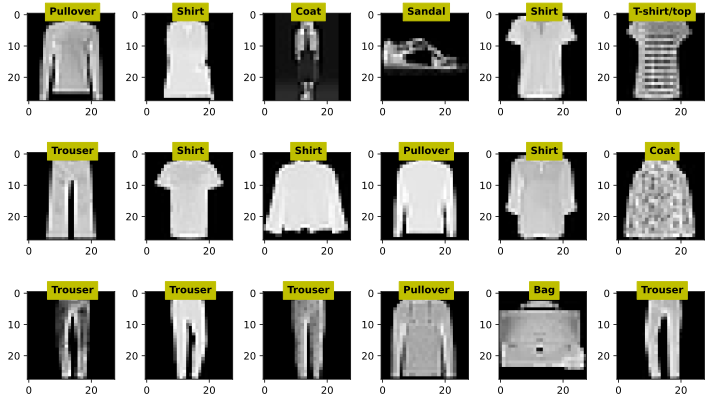

In [7]:
# inspect a few random images:

fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i,ax) in enumerate(axs.flatten()):

  # extract the image
  pic = torch.squeeze(X.data[i])
  pic = pic/2 + .5 # [-1,1] -> [0,1], undo normalization in order to be displayed accurately

  # and its label
  label = trainset.classes[y[i]]

  # visualize
  ax.imshow(pic,cmap='gray')
  ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y') # 28 pixels / 2 = 14
  # ax.axis('off')

plt.tight_layout()
plt.show()

# Create the DL model:

In [8]:
# build a class for the model & create a model instance:
def makeTheNet(printtoggle=False): # introduce variable

  # create a class for the model
  class cnnnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()
      self.print = printtoggle

      # -------------- convolutional & pooling layers --------------

      # 1st convolution layer
      self.conv1  = nn.Conv2d(1,16,3,padding=1) # (inChans, outChans, k, s, p)
      self.bnorm1 = nn.BatchNorm2d(16) # bnorm (batch normalization), 16 is the inChans in this layer
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

      # 2nd convolution layer
      self.conv2  = nn.Conv2d(16,32,3)
      self.bnorm2 = nn.BatchNorm2d(32)
      # output size: (14+2*0-3)/1 + 1 = 12/2 = 6 (/2 b/c maxpool)

      # -------------- fully connected layers --------------

      self.fc1 = nn.Linear(6*6*32,64)
      self.fc2 = nn.Linear(64,32)
      self.fc3 = nn.Linear(32,10)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # 1st block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # 2nd block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # fc layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.5,training=self.training) # dropout added
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=.5,training=self.training) # training=self.training=False during eval mode
      x = self.fc3(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = cnnnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [9]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print('\nloss:', loss)

Input: [32, 1, 28, 28]
First CPR block: [32, 16, 14, 14]
Second CPR block: [32, 32, 6, 6]
Vectorized: [32, 1152]
Final output: [32, 10]

Output size:
torch.Size([32, 10])

loss: tensor(2.2704, grad_fn=<NllLossBackward0>)


# Create a funciton to train the model:

In [10]:
# a function to train the model:
def function2trainTheModel():

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # send the model to the GPU
  net.to(device)

  # number of epochs
  numepochs = 10

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss   = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc    = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):
    net.train() # switch to train mode
    batchLoss = []
    batchAcc  = []

    # loop over training batches
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # record loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # record ave losses and accuracies across batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)


    # test performance
    net.eval() # switch to test mode
    X,y = next(iter(dev_loader))

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,y)

    # record ave losses and accuracies across the batches
    devLoss[epochi] = loss.item()
    devAcc[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

  # end epochs

  # function output
  return trainLoss,devLoss,trainAcc,devAcc,net

# Train the model & show the results:

In [11]:
# ~3 minutes with 10 epochs on GPU
trainLoss,devLoss,trainAcc,devAcc,net = function2trainTheModel()

In [12]:
# the real test set:

net.eval() # switch to test mode
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLoss = loss.item()
testAcc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

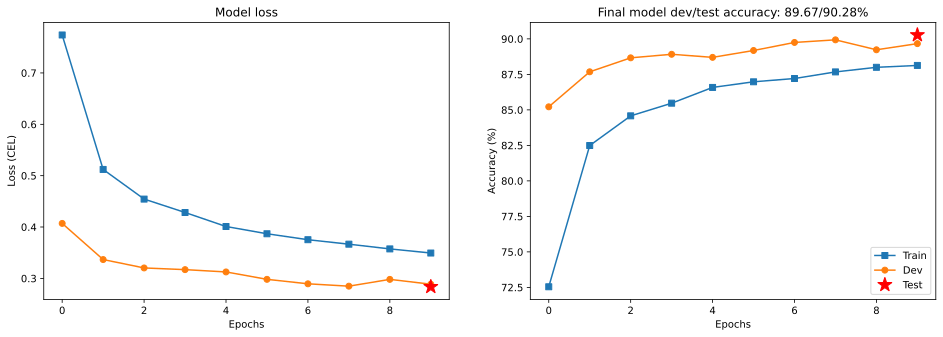

In [13]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].plot(len(devLoss)-1,testLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(len(devAcc)-1,testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].legend()

plt.show()